# Make a chi2 spectrum fit with mixed Fermi/H.E.S.S. data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u
from astropy.units import Quantity
from astropy.table import Table, vstack
from gammapy.spectrum import FluxPoints
from numpy import isnan

# Temporarily fixing environment variable for gamma-cat
import os
os.environ['GAMMA_CAT'] = os.path.join('C:/Users/Arjun/github/gamma-cat')

## The source

[HESS J1507-622](https://github.com/gammasky/fermi-hgps-paper/blob/master/analysis/plots/seds/HESS_J1507m622_sed_0.png) (this picture is from the new HESS data, I won't be using it).

- gamma-sky.net: http://gamma-sky.net/#/cat/tev/77

- gamma-cat: source id 77

- AKA 3FGL J1506.6-6219 (3FGL) and 2FHL J1507.4-6213 (2FHL)

- unidentified source. 

- I want to fit a PowerLaw spectral model to this source.


In [2]:
# Preparing Fermi data
from gammapy.catalog import SourceCatalog3FGL

cat_f = SourceCatalog3FGL()
source_f = cat_f['3FGL J1506.6-6219']

data_f = source_f.flux_points.table

data_f['e_ref'] = data_f['e_ref'].to('TeV')
data_f['e_min'] = data_f['e_min'].to('TeV')
data_f['e_max'] = data_f['e_max'].to('TeV')

dnde_err_f = data_f['dnde'] * (data_f['flux_errn'] / data_f['flux'])
data_f['dnde_err'] = dnde_err_f.to(data_f['dnde'].unit)

data_f

# where_are_NaNs = isnan(data_f)
# data_f[where_are_NaNs] = 0

e_ref,e_min,e_max,flux,flux_errn,flux_errp,eflux,eflux_errn,eflux_errp,is_ul,flux_ul,eflux_ul,dnde,dnde_err
TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),,1 / (cm2 s),erg / (cm2 s),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,float64,float64,float64,float64
0.000173205080757,0.0001,0.0003,3.54986e-08,1.1271e-08,1.09875e-08,8.65209e-12,2.74709e-12,2.67799e-12,False,nan,nan,0.000180007080937,5.71533417236e-05
0.000547722557505,0.0003,0.001,nan,nan,nan,nan,nan,nan,True,1.16393272798e-09,8.12801648903e-13,2.17380797837e-07,nan
0.00173205080757,0.001,0.003,4.9892e-10,1.97208e-10,2.08858e-10,1.21602e-12,4.80657e-13,5.09051e-13,False,nan,nan,2.52993839033e-07,1.00000774199e-07
0.00547722557505,0.003,0.01,1.82891e-10,5.46543e-11,6.15773e-11,1.27717e-12,3.81664e-13,4.30009e-13,False,nan,nan,2.65716043394e-08,7.94052959033e-09
0.0316227766017,0.01,0.1,1.08572e-10,3.11695e-11,3.61032e-11,2.05047e-12,5.88661e-13,6.81837e-13,False,nan,nan,1.27980441338e-09,3.67413027204e-10


In [3]:
# Preparing gamma-cat data
from gammapy.catalog import SourceCatalogGammaCat

cat_g = SourceCatalogGammaCat()
source_g = cat_g['HESS J1507-622']

data_g = source_g.flux_points.table
dnde_err_g = data_g['dnde'] * (data_g['dnde_errn'] / data_g['dnde'])
data_g['dnde_err'] = dnde_err_g.to(data_g['dnde'].unit)

In [4]:
print("Spectral info from Fermi:\n")

data_f.info()

print('\n', source_f.spectral_model.parameters)

Spectral info from Fermi:

<Table length=5>
   name     dtype        unit      n_bad
---------- ------- --------------- -----
     e_ref float64             TeV     0
     e_min float64             TeV     0
     e_max float64             TeV     0
      flux float32     1 / (cm2 s)     1
 flux_errn float32     1 / (cm2 s)     1
 flux_errp float32     1 / (cm2 s)     1
     eflux float32   erg / (cm2 s)     1
eflux_errn float32   erg / (cm2 s)     1
eflux_errp float32   erg / (cm2 s)     1
     is_ul    bool                     0
   flux_ul float64     1 / (cm2 s)     4
  eflux_ul float64   erg / (cm2 s)     4
      dnde float64 1 / (cm2 s TeV)     0
  dnde_err float64 1 / (cm2 s TeV)     1

 ParameterList
Parameter(name='index', value=1.8567168712615967, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=2.013417644414206e-14, unit=Unit("1 / (cm2 MeV s)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=6664.8046875, unit=Unit("

In [5]:
print("Spectral info from H.E.S.S.:\n")

data_g.info()

print('\n', source_g.spectral_model.parameters)

Spectral info from H.E.S.S.:

<Table length=6>
   name    dtype        unit      n_bad
--------- ------- --------------- -----
    e_ref float32             TeV     0
     dnde float32 1 / (cm2 s TeV)     0
dnde_errp float32 1 / (cm2 s TeV)     0
dnde_errn float32 1 / (cm2 s TeV)     0
  dnde_ul float32 1 / (cm2 s TeV)     6
 dnde_err float32 1 / (cm2 s TeV)     0

 ParameterList
Parameter(name='index', value=2.490000009536743, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=3.100000074349185e-12, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)

Covariance: [[  3.24000026e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   6.39999978e-25   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]


## Combining source data

`data_combined` contains all data from SourceCatalog3FGL and SourceCatalogGammaCat in the columns `e_ref`, `dnde`, and `dnde_err`.

In [6]:
colnames=['e_ref', 'dnde', 'dnde_err']

data_combined = vstack([
                    data_f[colnames], 
                    data_g[colnames]
                    ])

flux_points = FluxPoints(data_combined)

flux_points.table

mask = ~np.isnan(flux_points.table['dnde_err'])
flux_points.table = flux_points.table[mask]

flux_points.table

e_ref,dnde,dnde_err
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64
0.000173205080757,0.000180007080937,5.71533417236e-05
0.00173205080757,2.52993839033e-07,1.00000774199e-07
0.00547722557505,2.65716043394e-08,7.94052959033e-09
0.0316227766017,1.27980441338e-09,3.67413027204e-10
0.860900402069,2.29119002416e-12,8.70542678742e-13
1.56151199341,6.98171717921e-13,2.20354116898e-13
2.76375293732,1.69061501452e-13,6.75869814759e-14
4.89159679413,7.72924882734e-14,2.40131790727e-14


## Plot data and model

We'll be plotting the spectral model for the source as given by `SourceCatalogObject3FGL`.

<Container object of 3 artists>

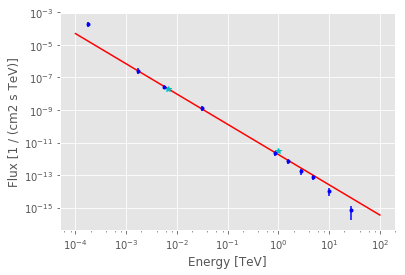

In [17]:
# Defining units
energy_range = [1e-4, 100] * u.TeV
opts = dict(energy_unit='TeV', flux_unit='cm-2 s-1 TeV-1', energy_range=energy_range)

source_f.spectral_model.plot(**opts, color='r')
# Using the combined energy range to stretch to gamma-cat data

p_f = source_f.spectral_model.parameters
p_g = source_g.spectral_model.parameters
plt.plot(p_f['reference'].value / 1e6, p_f['amplitude'].value * 1e6, '*', color='c')
plt.plot(p_g['reference'].value, p_g['amplitude'].value, '*', color='c')



# Combined 3FGL + gamma-cat:
# TODO: Split the colors for the flux points (first 5 purple, last 6 red)
# Instead of the below code, I can call plt.errorbar() for each catalog individually. 

plt.errorbar(x=flux_points.table['e_ref'],
             y=flux_points.table['dnde'],
             yerr=flux_points.table['dnde_err'],
             fmt='.',
             color='b'
            )

## Defining chi2 function

In [8]:
from gammapy.spectrum.models import PowerLaw

class MyChi2:

    def __init__(self, flux_points, spectral_model):
        self.flux_points = flux_points
        self.spectral_model = spectral_model
    
    def __call__(self, amplitude, index):

        t = self.flux_points.table
        
        dnde_model = PowerLaw.evaluate( # Should be calling: spectral_model.evaluate()
            energy=t['e_ref'],
            amplitude=amplitude,
            index=index,
            reference=1 # 1 TeV
        )

        chi = (t['dnde'] - dnde_model) / t['dnde_err']
        return np.sum(chi ** 2)

## Defining Chi2Fitter class and running a fit

In [9]:
from iminuit import Minuit

class Chi2Fitter(object):
    def __init__(self, flux_points, spectral_model):
        self.flux_points = flux_points
        self.spectral_model = spectral_model
        self.minuit = None
    
    def fit(self):

        chi2 = MyChi2(self.flux_points, self.spectral_model)
        
        pars = dict(
            amplitude=self.spectral_model.parameters['amplitude'].value,
            index = self.spectral_model.parameters['index'].value
        )
        
        minuit = Minuit(chi2, **pars)
        
        minuit.migrad()
        minuit.hesse()
        
        self.minuit = minuit

In [25]:
spectral_model = PowerLaw(
    reference=1,
    amplitude=1e-1, # p_g['amplitude'].value 
    index=2.0 # p_g['index'].value
)

fitter = Chi2Fitter(flux_points=flux_points, spectral_model=spectral_model)
fitter.fit()

print(fitter.minuit.values)
print('\n', fitter.minuit.errors)


        
fitter.flux_points.table.pprint()

C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: InitialParamWarning: errordef is not given. Default to 1.
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
C:\Users\Arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.


FCN = 14.492342732535066 
 TOTAL NCALL = 159 
 NCALLS = 159 
 
 
 EDM = 1.2547266042364373e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.10674e-12,1.56687e-13,0,0,,,
2,index,1.97658,0.0328586,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.10674e-12,1.56687e-13,0,0,,,
2,index,1.97658,0.0328585,0,0,,,


+,amplitude,index
amplitude,1.00,-0.48
index,-0.48,1.00


{'index': 1.9765784488921638, 'amplitude': 1.106736106383897e-12}

 {'index': 0.03285849901258569, 'amplitude': 1.5668653906187803e-13}
      e_ref              dnde            dnde_err    
       TeV         1 / (cm2 s TeV)   1 / (cm2 s TeV) 
----------------- ----------------- -----------------
0.000173205080757 0.000180007080937 5.71533417236e-05
 0.00173205080757 2.52993839033e-07 1.00000774199e-07
 0.00547722557505 2.65716043394e-08 7.94052959033e-09
  0.0316227766017 1.27980441338e-09 3.67413027204e-10
   0.860900402069 2.29119002416e-12 8.70542678742e-13
    1.56151199341 6.98171717921e-13 2.20354116898e-13
    2.76375293732 1.69061501452e-13 6.75869814759e-14
    4.89159679413 7.72924882734e-14 2.40131790727e-14
    9.98858356476 1.03253400974e-14 5.06314706551e-15
    27.0403499603 7.44986705873e-16 5.72089017191e-16


## Final plot

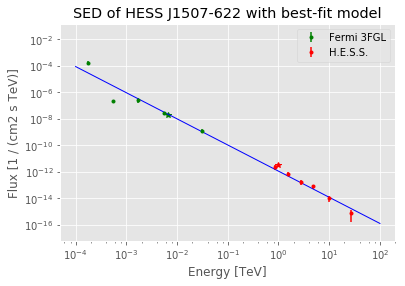

In [69]:
source_g.spectral_model.plot(linestyle='dashed', alpha=0, **opts)
# source_f.spectral_model.plot(linestyle='dashed', alpha=0.7, **opts)

plt.plot(p_f['reference'].value / 1e6, p_f['amplitude'].value * 1e6, '*', color='g')
plt.plot(p_g['reference'].value, p_g['amplitude'].value, '*', color='r')

fermi = plt.errorbar(x=data_f['e_ref'],
             y = data_f['dnde'],
             yerr = data_f['dnde_err'],
             fmt='.',
             color='g'
            )

hess = plt.errorbar(x=data_g['e_ref'],
             y = data_g['dnde'],
             yerr = data_g['dnde_err'],
             fmt='.',
             color='r'
            )


from gammapy.utils.energy import Energy
energy = Energy.equal_log_spacing(
    emin=energy_range[0],
    emax=energy_range[1],
    nbins=100,
)

spectral_model = PowerLaw(
    index=fitter.minuit.values['index'],
    amplitude=fitter.minuit.values['amplitude'],
    reference=1
    )

flux = spectral_model(
    energy=energy.to('TeV').value
#     amplitude = fitter.minuit.values['amplitude'],
#     index = fitter.minuit.values['index'],
#     reference=1,
)
plt.plot(energy, flux, linewidth=1, color='blue')

plt.legend([fermi, hess], ['Fermi 3FGL', 'H.E.S.S.'])

plt.title('SED of HESS J1507-622 with best-fit model')

## Reduced Minimum

Indicates the goodness of fit between flux points and the model. Chi2 value divided by degrees of freedom.

Degrees of freedom = total data points - number of parameters in function (index + amplitude = 2)

In [65]:
print('\nMinimum value of function: ', fitter.minuit.fval)

result = fitter.minuit.fval / (len(flux_points.table) - len(fitter.minuit.args))
print('\nReduced minimum: ', result)


Minimum value of function:  14.492342732535066

Reduced minimum:  1.8115428415668833
